# Merger rate density for high mass ratio binary black holes

Assume the primary black hole is stellar in origin and the secondary is primordial:

 $R =  \sum_\mathrm{halos}  
        \int_0^{\sqrt[3]{2}R_\mathrm{halfmass}} \frac{\rho_\mathrm{NFW}(r)}{M_\mathrm{PBH}} \
        \frac{\rho_\mathrm{BH}}{M_\mathrm{BH}}
        \sigma v \
        4\pi r^2 dr$    

In [1]:
import illustris_python as il

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

G = 6.67e-11 # in SI
c = 3e8 # in SI
kpc = 1000 * 3.086e16 # in SI(m)
solarmass = 1.988435e30 # in kg
h = 0.704 # Hubble constant in 100 km/s/Mpc
year = 3.154e7 # 1 year in seconds

We use the dark matter main subhalo samples from the IllustrisTNG simulation. To implement the following, one needs to download the redshift =0 snapshot for 'TNG100-highres', i.e., the No.135 Groupcat in https://www.illustris-project.org/data/downloads/Illustris-3/

In [2]:
basePath = './TNG100-highres/'
Subhalos = il.groupcat.loadSubhalos(basePath,99,fields=['SubhaloVmax','SubhaloVmaxRad','SubhaloHalfmassRad','SubhaloHalfmassRadType','SubhaloMassType','SubhaloVelDisp','SubhaloMass'])
Halos = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub','Group_R_Crit200'])

In [3]:
#Select the Main Subhalo given by the 'GroupFirstSub' index
MainSubhalo = {}
MainSubhalo['Vmax']= Subhalos['SubhaloVmax'][Halos['GroupFirstSub'][:]]
MainSubhalo['VmaxRad']= Subhalos['SubhaloVmaxRad'][Halos['GroupFirstSub'][:]]
MainSubhalo['HalfmassRadTypeStar'] = Subhalos['SubhaloHalfmassRadType'][Halos['GroupFirstSub'][:]][:,4] #The 4th column for Star
#MainSubhalo['StarMass'] = Subhalos['SubhaloMassType'][Halos['GroupFirstSub'][:]][:,4]
MainSubhalo['VelDisp'] = Subhalos['SubhaloVelDisp'][Halos['GroupFirstSub'][:]]
MainSubhalo['TotalMass'] = Subhalos['SubhaloMass'][Halos['GroupFirstSub'][:]]
MainSubhalo['HalfmassRad'] = Subhalos['SubhaloHalfmassRad'][Halos['GroupFirstSub'][:]]

#Select those with Star Formation Rate(SFR) > 0
MainSubhalo['Vmax']= MainSubhalo['Vmax'][np.where(MainSubhalo['HalfmassRadTypeStar']>0)]
MainSubhalo['VmaxRad']= MainSubhalo['VmaxRad'][np.where(MainSubhalo['HalfmassRadTypeStar']>0)]
MainSubhalo['VelDisp'] = MainSubhalo['VelDisp'][np.where(MainSubhalo['HalfmassRadTypeStar']>0)]
MainSubhalo['TotalMass'] = MainSubhalo['TotalMass'][np.where(MainSubhalo['HalfmassRadTypeStar']>0)]
MainSubhalo['HalfmassRad'] = MainSubhalo['HalfmassRad'][np.where(MainSubhalo['HalfmassRadTypeStar'])]
MainSubhalo['HalfmassRadTypeStar'] = MainSubhalo['HalfmassRadTypeStar'][np.where(MainSubhalo['HalfmassRadTypeStar'])]

MainSubhalo['VelDisp'] = np.float64(MainSubhalo['VelDisp'])

There ~$10^5$ main subhalos with non-zero star formation rate

In [4]:
np.size(MainSubhalo['TotalMass'])

113455

In [5]:
MainSubhalo

{'Vmax': array([999.38513 , 959.35266 , 983.8356  , ...,  13.835034,  10.112929,
         12.982614], dtype=float32),
 'VmaxRad': array([3.2782806e+02, 9.6035663e+02, 6.1957056e+02, ..., 9.0901667e-01,
        1.4886290e+00, 1.8065341e+00], dtype=float32),
 'HalfmassRadTypeStar': array([47.388058 , 88.33855  , 58.37313  , ...,  2.4563506,  5.417963 ,
         4.716274 ], dtype=float32),
 'VelDisp': array([603.87506104, 594.97125244, 567.02929688, ...,   5.28624725,
          4.7164011 ,   4.87724113]),
 'TotalMass': array([2.7477936e+04, 2.7463623e+04, 2.3211328e+04, ..., 1.5768630e-02,
        1.1256111e-02, 1.1290176e-02], dtype=float32),
 'HalfmassRad': array([607.9657   , 682.5038   , 520.0225   , ...,   2.9664137,
          2.6135285,   1.5544378], dtype=float32)}

# NFW profile

In [6]:
G_for_NFW = G /(1000)**2 *h/kpc * solarmass # the dimension of G is [v]**2[R]/[m], 
                                           # we convert the unit of [v] to km/s, [R] to ckpc/h, [m] to solar mass

def NFWProfilePar(SubhaloVmax,SubhaloVmaxRad):
    '''
    Input: 
        Unit of SubhaloVmax: km/s 
        Unit of SubhaloVmaxRad (Rmax): ckpc/h (comoving kpc / hubble constant 0.704)
    
    Equations:
        Rs = Rmax / 2.163 #2.163 is a numerical factor
        Rhos = (Vmax / Rs )**2 / (4pi G) * (1+2.163)**2/2.163
    
    Output:
        Unit of Rs: ckpc/h
        Unit of Rhos: M_solar / (ckpc/h)^3
    
    Reference: The note from Shihong Liao
    '''
    Rs = SubhaloVmaxRad / 2.163
    Rhos = (SubhaloVmax/Rs) **2 / (4*np.pi*G_for_NFW) * (1+2.163)**2/2.163
    return [Rhos,Rs]

def NFWProfile(Radius,Rhos,Rs):
    return Rhos/(Radius/Rs)/(1+Radius/Rs)**2

In [7]:
MainSubhalo['NFWRhos'], MainSubhalo['NFWRs'] = NFWProfilePar(MainSubhalo['Vmax'],MainSubhalo['VmaxRad'])

In [8]:
MainSubhalo['NFWRhos'], MainSubhalo['NFWRs']

(array([5.28937850e+06, 5.67966312e+05, 1.43514112e+06, ...,
        1.31840216e+08, 2.62670960e+07, 2.93942940e+07], dtype=float32),
 array([1.5156174e+02, 4.4399286e+02, 2.8644037e+02, ..., 4.2025733e-01,
        6.8822420e-01, 8.3519834e-01], dtype=float32))

# Gravitational Encounter Cross Section

In [9]:
def CrossSection(Mass1, Mass2, Vrel):
    '''
    Input: 
        Mass1, Mass2 (solarmass), Vrel(km/s)
        
    Output:
        CrossSection [(ckpc/h)**2]
    Ref: 
        https://iopscience.iop.org/article/10.1086/339472/pdf
    '''
    Mass1SI = Mass1 * solarmass
    Mass2SI = Mass2 * solarmass
    VrelSI = Vrel*1000
    CSunitconvert = (h/kpc)**2
    return 2*np.pi*(85*np.pi/6/np.sqrt(2))**(2/7)*G**2*(Mass1SI+Mass2SI)**(10/7)*(Mass1SI*Mass2SI)**(2/7)/c**(10/7)/VrelSI**(18/7)*CSunitconvert

 Rate for 0.01$M_\odot$ -37$M_\odot$ high mass ratio binaries

### $R = 4\pi \sigma v  \frac{0.006\%*M_\mathrm{TotalMass}}{M_\mathrm{BH}\frac{4}{3}\pi (\sqrt[3]{2}R_\mathrm{halfmass})^3}\int_0^{\sqrt[3]{2}R_\mathrm{halfmass}}r^2 \frac{\rho_\mathrm{NFW}(r)}{M_\mathrm{PBH}}  dr$

In [10]:
MassPBH = 0.01
MassBH = 37

ratelowlim = 0
rateupplimArray = np.cbrt(2)*MainSubhalo['HalfmassRadTypeStar']

In [11]:
def RateIntegrand(Radius,NFWRhos,NFWRs,MassPBH):
    '''
    Radius: ckpc/h
    MassPBH, MassBH (M_\odot)
    
    '''
    return Radius**2 * NFWProfile(Radius,NFWRhos,NFWRs)/MassPBH

# The dimension for the result of RateResult is 1.
RateResult = []

for i in range(np.size(MainSubhalo['NFWRhos'])):
    RateCache,err=integrate.quad(RateIntegrand,ratelowlim,rateupplimArray[i],\
        args=(MainSubhalo['NFWRhos'][i], MainSubhalo['NFWRs'][i],MassPBH)
        )
    RateResult.append(RateCache)

In [12]:
Multiplier = 4*np.pi*CrossSection(MassPBH, MassBH,MainSubhalo['VelDisp'])\
              *np.sqrt(3)*MainSubhalo['VelDisp']*1000*(h/kpc)*year \
              *MainSubhalo['TotalMass']*1e10/h/(MassBH)*0.006*0.01 / ( 4/3*np.pi*(np.cbrt(2)*MainSubhalo['HalfmassRadTypeStar'])**3 )

The merger rate density in the unit of per 100Mpc^3 per year is:

In [13]:
np.sum(RateResult * Multiplier)

1.2056585048829798e-07

# Assume both primary and secondary mass are primordial in origin

In [14]:
#load files
OGCfile = np.loadtxt('./rate-2ogc.txt')
pbhmass = OGCfile[:,0]

searchogc = OGCfile[:,1]
search20= np.loadtxt('./rate_20.txt')
search50= np.loadtxt('./rate_50.txt')
ligo = np.loadtxt('./figdataligo.txt')

Constraints with fixed f_pbh(primary) = 3e-3

In [15]:
def RateFuncForFixedFm1(m1,m2,p_m1):
    f_pbh_m1 = 3e-3
    p1 = p_m1
    p2 = 1-p1
    f = f_pbh_m1/p_m1
    sigma_eq = 0.005
    return 3.3e6*f**2*(0.7*f**2+sigma_eq**2)**(-21./74)*min(p1/m1,p2/m2)*(p1/m1+p2/m2)*(m1*m2)**(3./37)*(m1+m2)**(36./37)

In [16]:
primass=37
rateresult = searchogc
        
ResultOGC = []

for i,_ in enumerate(pbhmass):
    def CacheFunction(p_m1):
        return RateFuncForFixedFm1(primass,pbhmass[i],p_m1)-rateresult[i]
    sol = optimize.root_scalar(CacheFunction, bracket=[1e-5, 1], method='brentq')
    ResultOGC.append(sol.root)

In [17]:
primass=20
rateresult = search20
        
Result20 = []

for i,_ in enumerate(pbhmass):
    def CacheFunction(p_m1):
        return RateFuncForFixedFm1(primass,pbhmass[i],p_m1)-rateresult[i]
    sol = optimize.root_scalar(CacheFunction, bracket=[1e-5, 1], method='brentq')
    Result20.append(sol.root)

In [18]:
primass=50
rateresult = search50
        
Result50 = []

for i,_ in enumerate(pbhmass):
    def CacheFunction(p_m1):
        return RateFuncForFixedFm1(primass,pbhmass[i],p_m1)-rateresult[i]
    sol = optimize.root_scalar(CacheFunction, bracket=[1e-8, 1], method='brentq')
    Result50.append(sol.root)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


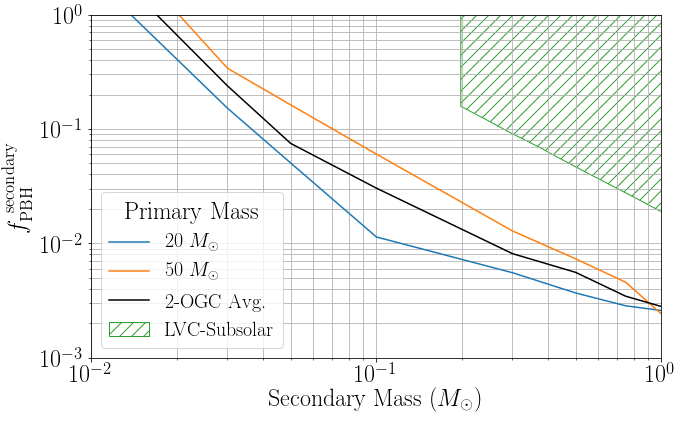

In [19]:
plt.plot(pbhmass,3e-3/np.array(Result20)*(1-np.array(Result20)),label='20 $M_\odot$')
plt.plot(pbhmass,3e-3/np.array(Result50)*(1-np.array(Result50)),label='50 $M_\odot$')
plt.plot(pbhmass,3e-3/np.array(ResultOGC)*(1-np.array(ResultOGC)),color='k',label='2-OGC Avg.')
plt.fill_between(ligo[:,0],ligo[:,1],1, hatch='//',facecolor='none',linewidth=1,edgecolor='tab:green',label='LVC-Subsolar')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.xlim(0.01,1)
plt.ylim(1e-3,1)
plt.legend(title='Primary Mass',loc='lower left')
plt.xlabel(r'Secondary Mass$~(M_\odot)$ ')
plt.ylabel(r'$f_\mathrm{PBH}^{~\mathrm{secondary}}$')
plt.grid(True,which="both")
#plt.savefig('0706-fixfm1.pdf',bbox_inches='tight')